<a href="https://colab.research.google.com/github/ohbseok/mobility_subscription/blob/main/ML_PJ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

pd.set_option('display.max_columns', None)

In [ ]:
### station 마다 수요공급 예측할 때 
# df = pd.read_csv('/content/drive/MyDrive/코드스테이츠/N2XX/section2 project/status3.csv')
df_station = pd.read_csv('/content/drive/MyDrive/코드스테이츠/N2XX/section2 project/station.csv')
df_trip = pd.read_csv('/content/drive/MyDrive/코드스테이츠/N2XX/section2 project/trip.csv.zip')

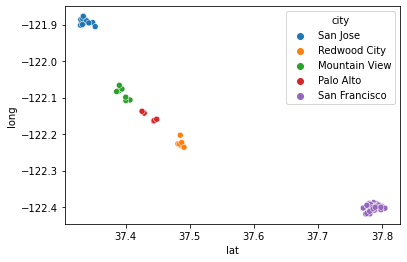

In [ ]:
sns.scatterplot(data=df_station, x='lat', y='long', hue='city')

In [ ]:
df_trip

,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type
0,63,8/29/2013 14:13,66,8/29/2013 14:14,66,520,Subscriber
1,70,8/29/2013 14:42,10,8/29/2013 14:43,10,661,Subscriber
2,71,8/29/2013 10:16,27,8/29/2013 10:17,27,48,Subscriber
3,77,8/29/2013 11:29,10,8/29/2013 11:30,10,26,Subscriber
4,83,8/29/2013 12:02,66,8/29/2013 12:04,67,319,Subscriber
...,...,...,...,...,...,...,...
669954,619,9/1/2014 4:21,39,9/1/2014 4:32,65,335,Subscriber
669955,6712,9/1/2014 3:16,50,9/1/2014 5:08,70,259,Customer
669956,538,9/1/2014 0:05,66,9/1/2014 0:14,57,466,Customer
669957,568,9/1/2014 0:05,66,9/1/2014 0:15,57,461,Customer


In [ ]:
# 쓸모 없는 feature 제거
df_trip.drop(columns=['id', 'start_station_name', 'end_station_name', 'zip_code'], inplace=True) # bike_id 도 추가?
df_station.drop(columns=['name'], inplace=True)

In [ ]:
# 결측치 확인
print(df_trip.isnull().sum(), '\n') 
print(df_trip.isnull().sum())

duration             0
start_date           0
start_station_id     0
end_date             0
end_station_id       0
bike_id              0
subscription_type    0
dtype: int64 

duration             0
start_date           0
start_station_id     0
end_date             0
end_station_id       0
bike_id              0
subscription_type    0
dtype: int64


In [ ]:
df_merge = pd.merge(df_trip, df_station[['id', 'lat', 'long', 'city']], how='left', left_on='start_station_id', right_on='id')
# df_merge.drop(columns=['id', 'installation_date'], inplace=True) # 


In [ ]:
# column 삭제 및 네임 변경
df_merge.drop(columns='id', inplace=True) 
df_merge.rename(columns = {'lat' : 'start_lat', 'long':'start_long', 'city':'start_city'}, inplace = True)


In [ ]:
# end point 병합
df_merge = pd.merge(df_merge, df_station[['id', 'lat', 'long', 'city']], how='left', left_on='end_station_id', right_on='id') # df_merge 에 해주는거 조심


In [ ]:
# column 삭제 및 네임 변경
df_merge.drop(columns='id', inplace=True) 
df_merge.rename(columns = {'lat' : 'end_lat', 'long':'end_long', 'city':'end_city'}, inplace = True)


In [ ]:
df = df_merge

In [ ]:
# city 이동 column 추가 -> 무조건 ['col'] 으로!  df.col 은 참조임
df['move_city'] = df.start_city + '_' + df.end_city # - 쓰면 num 계산으로 인식

In [ ]:
df.move_city.value_counts() # 데이터별 개수 확인 -> 맞다 이거였네

San Francisco_San Francisco    603693
San Jose_San Jose               37856
Mountain View_Mountain View     17746
Palo Alto_Palo Alto              6293
Redwood City_Redwood City        3329
Palo Alto_Mountain View           420
Mountain View_Palo Alto           393
Redwood City_Palo Alto             97
Palo Alto_Redwood City             51
Mountain View_San Jose             15
San Jose_Mountain View             14
Palo Alto_San Francisco             9
Mountain View_San Francisco         9
San Francisco_Redwood City          6
San Francisco_Palo Alto             4
San Jose_San Francisco              4
Mountain View_Redwood City          4
San Jose_Palo Alto                  4
San Francisco_San Jose              3
Redwood City_Mountain View          3
Redwood City_San Francisco          3
San Francisco_Mountain View         2
Redwood City_San Jose               1
Name: move_city, dtype: int64

# haversine

- haversine 패키지 -> 기본 단위 KM


In [ ]:
!pip install haversine
from haversine import haversine

df['distance_diagonal'] = df.apply(lambda row: haversine((row['start_lat'], row['start_long']),
                                                        (row['end_lat'], row['end_long'])), axis=1)

df['distance_lat'] = df.apply(lambda row: haversine((row['start_lat'], row['start_long']),
                                                        (row['end_lat'], row['start_long'])), axis=1)

df['distance_long'] = df.apply(lambda row: haversine((row['start_lat'], row['start_long']),
                                                        (row['start_lat'], row['end_long'])), axis=1)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 블럭 이동거리 a+b 생성
df['distance_lat+long'] = df['distance_lat'] + df['distance_long']

coords = df[['start_lat',	'start_long',	'end_lat','end_long']] # lat, long 좌표 따로
df.drop(columns=['distance_lat', 'distance_long','start_lat',	'start_long',	'end_lat','end_long'], inplace=True) # 

In [ ]:
# right skewed 데이터-> log transformation 
def log_transform(df, col_list):
  for col in col_list:
    df[col] = np.log1p(df[col])


In [ ]:
col_list = ['duration', 'distance_diagonal', 'distance_lat+long']
log_transform(df, col_list)

In [ ]:
# target -> 0, 1 로 변경
df = df.replace({'subscription_type' : 'Subscriber'}, 1) # 되네
df.replace({'subscription_type': {'Customer': 0}}, inplace=True) # 둘다 가능 -> 이걸로 하면 한번에 가능

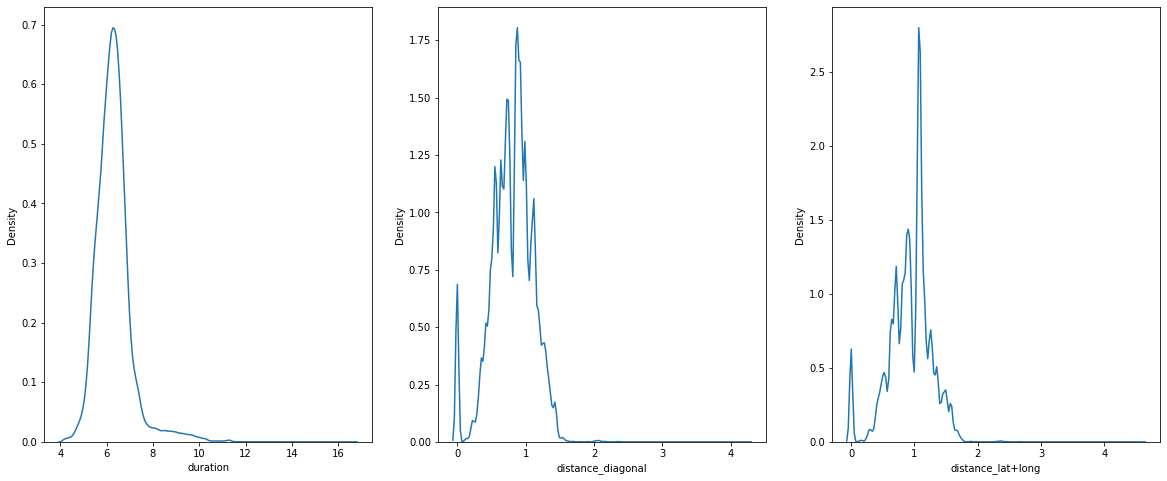

In [ ]:
# 이동시간 커널밀도추정 그래프
plt.figure(figsize=(20, 8))

plt.subplot(1,3, 1)
sns.kdeplot(df['duration'])

plt.subplot(1,3, 2)
sns.kdeplot(df['distance_diagonal'])

plt.subplot(1,3, 3)
sns.kdeplot(df['distance_lat+long'])

# 다시 출발 정류소로 오는 데이터

In [ ]:
# 이동시간 이상치 확인
# limit = df['duration'].quantile(0.995) # 99.5% -> 20636
limit_1day = np.log1p(86400)
limit_1min = np.log1p(60)

# 이동시간 1일보다 크면 제외
df = df[df.duration < limit_1day] 

# 이동시간 1분 이하 & 원래 정류소로 돌아오면 삭제
df_remove = df[ (df.duration <= limit_1min) & (df.start_station_id == df.end_station_id) ] # duration log transform 해줬으니 60초도 변환해주기!!
remove_list = list(df_remove.index) # [] 로 감싸면 다름
df.drop(index=remove_list, inplace=True)

In [ ]:
# 다시 출발했던 정류소로 돌아오는지 아닌지 feature engineering
df['is_comeback'] = df.apply(lambda x: 1 if x.start_station_id == x.end_station_id else 0, axis=1) # 기본 axis=0 -> each col 기능 적용, x 에 df 들어간다 생각  


In [ ]:
df.is_comeback.value_counts()

0    645784
1     23833
Name: is_comeback, dtype: int64

In [ ]:
# 다시 출발 정류소로 되돌아오는 경우
df_back = df[df.is_comeback == 1]

# 그때 비율
print('전체 개수 :', len(df_back))
print('비율 :' ,len(df_back) / len(df)) 
print('다시 출발 정류소로 돌아오는 경우 :', df.is_comeback.value_counts(1)[1] ) 

전체 개수 : 23833
비율 : 0.03559198765861679
다시 출발 정류소로 돌아오는 경우 : 0.03559198765861679


- 다시 출발 정류소로 돌아오는 경우 vs 전체  
이동시간 -> 전체가 평균 시간에서 밀도가 훨씬 높다

In [ ]:
df_back.subscription_type.value_counts(1) # 와,,, 일반 고객 비율이 엄청 높다. 
# df_back.sort_values(by='duration', )

0    0.68573
1    0.31427
Name: subscription_type, dtype: float64

# 출도착 도시 다른 데이터



---
아예 customer인 사람만 뽑아서 특징 시각화?




In [ ]:
# 출도착 도시가 같은지 다른지 feature engineering
df['is_same_city'] = df.apply(lambda x: 1 if x.start_city == x.end_city else 0, axis=1) # 기본 axis=0 -> each col 기능 적용, x 에 df 들어간다 생각  



In [ ]:
print('출도착 도시 다른 경우 :', df.is_same_city.value_counts(1)[0] )

출도착 도시 다른 경우 : 0.0015411795100781491


In [ ]:
df_diff = df[df.is_same_city == 0]

In [ ]:
# 출도착 도시 다를 때 이동 도시
print(df_diff.move_city.value_counts(), '\n')
print(df_diff.subscription_type.value_counts(2)) # 이때 일반 고객 비율 50프로

Palo Alto_Mountain View        418
Mountain View_Palo Alto        391
Redwood City_Palo Alto          97
Palo Alto_Redwood City          51
Mountain View_San Jose          14
San Jose_Mountain View          13
Palo Alto_San Francisco          9
Mountain View_San Francisco      7
San Francisco_Redwood City       6
San Francisco_Palo Alto          4
Mountain View_Redwood City       4
San Jose_San Francisco           4
San Jose_Palo Alto               3
Redwood City_San Francisco       3
Redwood City_Mountain View       3
San Francisco_San Jose           3
San Francisco_Mountain View      2
Name: move_city, dtype: int64 

0    0.506783
1    0.493217
Name: subscription_type, dtype: float64


In [ ]:
df_diff['duration'].describe()

count    1032.000000
mean        7.734885
std         0.958425
min         5.468060
25%         7.210079
50%         7.384610
75%         7.869493
max        11.346091
Name: duration, dtype: float64

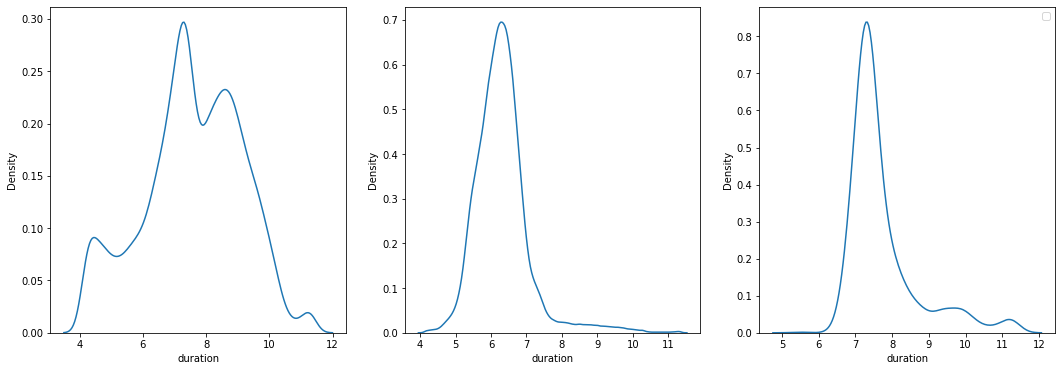

In [ ]:
# 이동시간 커널밀도추정 그래프
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(df_back['duration'])

plt.subplot(1, 3, 2)
sns.kdeplot(df['duration'])

plt.subplot(1, 3, 3)
sns.kdeplot(df_diff['duration'])

plt.legend()


- 전체(2번째 plt)보다 다른 도시를 이동할 때 평균값 밀도가 더 높음! 

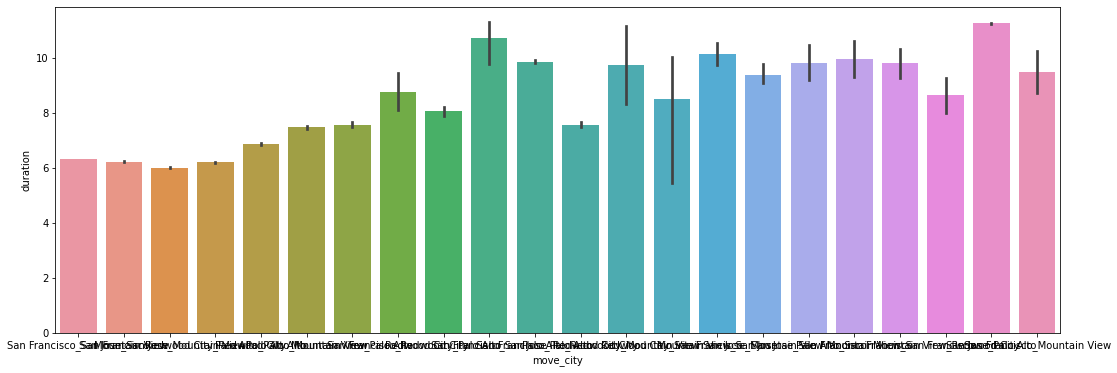

In [ ]:
plt.figure(figsize=(18, 6))

sns.barplot(data= df, x= "move_city", y='duration')

- 다른 도시를 오갔다면, 그때 각 경로마다 이동시간은?

In [ ]:
df_diff.move_city.unique()

array(['Palo Alto_Mountain View', 'Mountain View_Palo Alto',
       'San Francisco_Redwood City', 'Redwood City_Palo Alto',
       'San Francisco_San Jose', 'San Francisco_Palo Alto',
       'Palo Alto_Redwood City', 'Redwood City_Mountain View',
       'Redwood City_San Francisco', 'Mountain View_San Jose',
       'San Jose_Mountain View', 'San Jose_San Francisco',
       'Palo Alto_San Francisco', 'Mountain View_San Francisco',
       'Mountain View_Redwood City', 'San Jose_Palo Alto',
       'San Francisco_Mountain View'], dtype=object)

# customer 데이터

In [ ]:
df_customer = df[df.subscription_type == 0]

In [ ]:
print(df_customer.duration.describe(), '\n') # 최저는 61초
print(df_customer.distance_diagonal.describe(), '\n')

count    102961.000000
mean          7.245704
std           1.130637
min           4.127134
25%           6.489205
50%           7.016610
75%           7.742402
max          11.366535
Name: duration, dtype: float64 

count    102961.000000
mean          0.726987
std           0.419096
min           0.000000
25%           0.507737
50%           0.796614
75%           1.010078
max           4.234867
Name: distance_diagonal, dtype: float64 



In [ ]:
print(len(df_customer[df_customer.distance_diagonal == 0]))
print(len(df_customer[df_customer.distance_diagonal == 0]) / len(df_customer)) # customer 중에 이동거리 0 인 비율


16343
0.15873000456483524


이동거리 0인 것 중에 duration 표시해서 높은 사람들은??? 

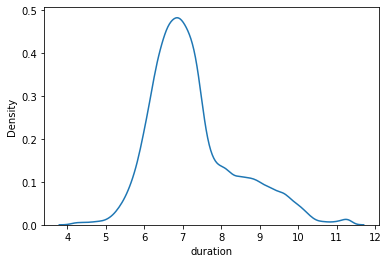

In [ ]:
sns.kdeplot(df_customer['duration']) 


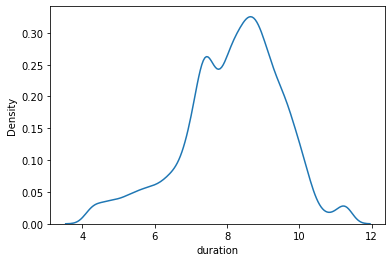

In [ ]:
sns.kdeplot(df_customer[df_customer.distance_diagonal == 0]['duration']) # customer 중 출도착 정류소 같은 사람의 dura


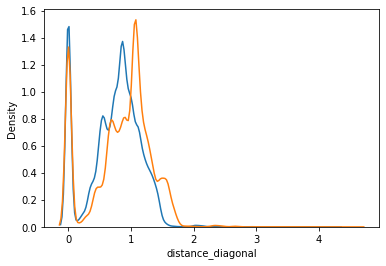

In [ ]:
# 이동거리 커널밀도추정 그래프
sns.kdeplot(df_customer['distance_diagonal'])
sns.kdeplot(df_customer['distance_lat+long'])

- 직각거리가 대각선보다 많이 나오는건 당연  
이동시간은 모두 60초 초과 -> 거리가 0이 나온다는건,, 출도착 정류소가 같다는 말  
<br>
모두 이동했다 가정하면 customer 은 1회 이용 고객일 가능성이 다분... (다시 출발지로 돌아가는)  


In [ ]:
df_num = df_customer[['duration', 'start_station_id', 'end_station_id', 'bike_id', 'distance_diagonal', 'distance_lat+long']]

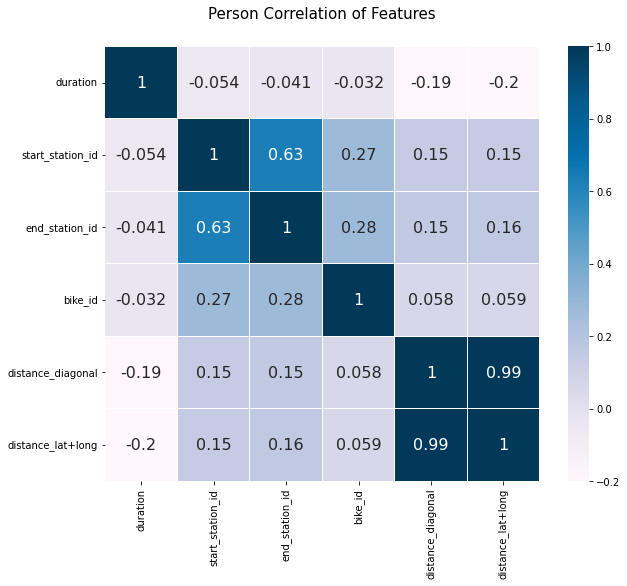

In [ ]:
heatmap_data = df_num

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title("Person Correlation of Features", y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16}) # annot -> 피어슨 계수 표시


In [ ]:
df['subscription_type'].value_counts(2)

1    0.846239
0    0.153761
Name: subscription_type, dtype: float64

# binary 문자열 column 상관 분석

In [ ]:
df_binary = df[['subscription_type', 'is_comeback', 'is_same_city']]

In [ ]:
df_binary

,subscription_type,is_comeback,is_same_city
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,0,1
...,...,...,...
669954,1,0,1
669955,0,0,1
669956,0,0,1
669957,0,0,1


In [ ]:
tau, p_value = scipy.stats.kendalltau(df_binary['subscription_type'], df_binary.is_comeback)
print(tau, p_value) # tau : correlation 계수


-0.28331023173022507 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


- 귀무 가설 : 서로 상관관계 없다  
p value < 0.5 -> 귀무가설 기각  
  -> 귀무가설이 실제로 참인데 이를 기각하는 오류 ->  1종 오류 , 0.5면 100번 중 최대 5번까지만 오류 허용  
  상관관계 있다 -> 값 신뢰 가능! 

In [ ]:
tau2, p_value3 = scipy.stats.kendalltau(df_binary['subscription_type'], df_binary.is_same_city)
print(tau2, p_value3) # tau : correlation 계수

0.03844975262410124 7.006538194252586e-218


In [ ]:
tau3, p_value3 = scipy.stats.kendalltau(df_binary.is_same_city, df_binary.is_comeback)
print(tau3, p_value3) # tau : correlation 계수

0.007547571752179554 5.063570690613981e-10


# 시계열 feature engineering

In [ ]:
from datetime import datetime, date, time

# 월,일,연, 시,분 으로 타입 변경
df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%Y %H:%M')

In [ ]:
# 계절 feature

def set_season(month):
  if 3 <= month <= 5 :
    return 'spring'
  elif 6 <= month <= 8 :
    return 'summer'  
  elif 9 <= month <= 11 :
    return 'fall'  
  elif  (month <= 2) or (month == 12) :
    return 'winter'   

In [ ]:
df['season'] = df['start_date'].dt.month.apply(set_season)
df['season'].value_counts(normalize=True)

summer    0.284899
spring    0.256527
fall      0.253706
winter    0.204868
Name: season, dtype: float64

In [ ]:
# 요일

def what_day(date):
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # 들어온 date(YYYY_MM_DD).weekday() -> 0-6까지 매핑된 결과로 출력 그래서 리스트에 변환
    day = date.weekday()
    return days[day]


In [ ]:
df['day'] = df['start_date'].dt.date.apply(what_day)
df['day'].value_counts(normalize=True)

Tue    0.182533
Wed    0.179450
Thu    0.177773
Mon    0.172990
Fri    0.163213
Sat    0.066781
Sun    0.057260
Name: day, dtype: float64

In [ ]:
# 평일 or 주말 feature

def check_weekend(date):
    weekday = date.weekday()
    if weekday <= 4:
        return 'weekdays'
    if weekday > 4:
        return 'weekend'

In [ ]:
df['is_weekend'] = df['start_date'].dt.date.apply(check_weekend)
df['is_weekend'].value_counts(2)

weekdays    0.875959
weekend     0.124041
Name: is_weekend, dtype: float64

In [ ]:
# 시간대 

def what_time(oclock):
  # input에 time 넣으면 안됨, 함수라서
  six = time(6)
  ten = time(10)
  seventeen = time(17)
  twenty_one = time(21)

  if (six <= oclock < ten) or (seventeen <= oclock < twenty_one) :
    return 'commute'
  elif (oclock < six) or (twenty_one <= oclock) :
    return 'night'  
  elif ten <= oclock < seventeen :
    return 'day'   

In [ ]:
df['time'] = df['start_date'].dt.time.apply(what_time)
df['time'].value_counts(1)

commute    0.58684
day        0.36541
night      0.04775
Name: time, dtype: float64

In [ ]:
df.drop(columns=['start_date', 'end_date'], inplace=True) # move_city 삭제?
# distance 0 인 것들 어떻게 처리할까?


randomforest 에서 nominal feature 어떻게 encoding 할까?

In [ ]:
df.head()
print(df.shape)

(669617, 16)


In [ ]:
df.head()

,duration,start_station_id,end_station_id,bike_id,subscription_type,start_city,end_city,move_city,distance_diagonal,distance_lat+long,is_comeback,is_same_city,season,day,is_weekend,time
0,4.158883,66,66,520,1,San Francisco,San Francisco,San Francisco_San Francisco,0.000000,0.000000,1,1,summer,Thu,weekdays,day
1,4.262680,10,10,661,1,San Jose,San Jose,San Jose_San Jose,0.000000,0.000000,1,1,summer,Thu,weekdays,day
2,4.276666,27,27,48,1,Mountain View,Mountain View,Mountain View_Mountain View,0.000000,0.000000,1,1,summer,Thu,weekdays,day
3,4.356709,10,10,26,1,San Jose,San Jose,San Jose_San Jose,0.000000,0.000000,1,1,summer,Thu,weekdays,day
4,4.430817,66,67,319,1,San Francisco,San Francisco,San Francisco_San Francisco,0.217942,0.291631,0,1,summer,Thu,weekdays,day


# 모델링


In [ ]:
# 데이터 전처리from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline # 뭔 차이?
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

!pip install category_encoders
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform



# 모델링
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier


# 모델 평가 및 해석
from sklearn.metrics import f1_score, roc_auc_score, auc, accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

def split(df):
    features = df.columns.drop('subscription_type')
    target = 'subscription_type'

    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], train_size = 0.8, test_size = 0.2, random_state = 42)
  
    return X_train, X_test, y_train, y_test

In [ ]:
# original
X_train, X_test, y_train, y_test = split(df)

# numeric
# X_train, X_test, y_train, y_test = split(trip_num)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(535693, 15) (133924, 15) (535693,) (133924,)


In [ ]:
print(y_resampled.value_counts())

1    453207
0    453207
Name: subscription_type, dtype: int64


# oversampling


In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from collections import Counter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.4) 
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({1: 453207, 0: 181282})


In [ ]:
def fit_cross_base(X_train, y_train):

    pipeline = make_pipeline(
        OneHotEncoder(),
        # TargetEncoder(),
        # OrdinalEncoder(), 
        StandardScaler(),
        LogisticRegression()
    )

   
    scores = cross_val_score(pipeline,X_train,y_train,cv=3,scoring='f1') # f1_micro 뭔 차이지?
    print('교차검증 f1_score : ', scores.mean())

In [ ]:
fit_cross_base(X_train, y_train)

교차검증 f1_score :  0.9436830939971275


In [ ]:
def fit_cross_lgbmC(X_train, y_train):

    pipeline = make_pipeline(
        OneHotEncoder(),
        # TargetEncoder(),
        # OrdinalEncoder(), 
        StandardScaler(),
        LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

        # LGBMRegressor(random_state=2, n_jobs=-1, ), # 목적함수, 오차 제곱 -> 최소화 하는 방향으로 학습
    )

   
    scores = cross_val_score(pipeline,X_train,y_train,cv=3,scoring='f1') # f1_micro 뭔 차이지?
    print('교차검증 f1_score: ', scores.mean())

In [ ]:
fit_cross_lgbmC(X_train, y_train)

교차검증 f1_score:  0.9533643594185816


In [ ]:
#불균형 처리
smotenc_list = list(X_train.dtypes == object)


smote_nc = SMOTENC(categorical_features=smotenc_list, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)


# hyper parameter tuning

In [ ]:
print(classification_report(y_val, y_pred))

In [ ]:
def lgbmc_tuning(X_train, y_train):

    pipeline = make_pipeline(
        OneHotEncoder(),
        StandardScaler(),
        LGBMClassifier(random_state=2, n_jobs=-1 ), # 목적함수, 오차 제곱 -> 최소화 하는 방향으로 학습
    )

    dists = {
      'lgbmclassifier__num_leaves': [20,40,60,80,100],
      'lgbmclassifier__min_child_samples': [5,10,15],
      'lgbmclassifier__max_depth': [-1,5,10,20],
      'lgbmclassifier__learning_rate': [0.05,0.1,0.2],
      'lgbmclassifier__reg_alpha': [0,0.01,0.03]

      }

    clf = RandomizedSearchCV(
        pipeline, 
        param_distributions=dists, 
        n_iter=5, 
        cv=3, 
        scoring='f1', # f1_macro, f1_weighted 등도 잇음
        verbose=1, # 이거 뭐였더라
        n_jobs=-1
    )

    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train,
            # early_stopping_rounds=20, # pipeline - early stopping 허용 안함
            # eval_metric='rmse',
            # eval_set=[(X_test, y_test)] #list(tuple()) 로 넣어줄 것
            )
    print("Optimal Hyperparameter:", clf.best_params_)
    print("f1 score:", -clf.best_score_)

    return clf

In [ ]:
clf_lgbmc = lgbmc_tuning(X_train, y_train) # 캬 확실히 빠르네

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Optimal Hyperparameter: {'lgbmclassifier__reg_alpha': 0, 'lgbmclassifier__num_leaves': 100, 'lgbmclassifier__min_child_samples': 15, 'lgbmclassifier__max_depth': 20, 'lgbmclassifier__learning_rate': 0.1}
RMSE: -0.9529011395109244


In [ ]:
final_pipe = clf_lgbmc.best_estimator_
print(final_pipe)

final_pipe.fit(X_train, y_train,
            # early_stopping_rounds=20, # pipeline - early stopping 허용 안함
            # eval_metric='rmse',
            # eval_set=[(X_test, y_test)] #list(tuple()) 로 넣어줄 것
            )



Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['start_city', 'end_city', 'move_city',
                                     'season', 'day', 'is_weekend', 'time'])),
                ('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=20, min_child_samples=15,
                                num_leaves=100, random_state=2, reg_alpha=0))])


In [ ]:
y_pred_final = final_pipe.predict(X_test) # train 데이터로 꼭 학습 시키고 예측!!

In [ ]:
# y_pred_final = xgbr.predict(X_test_encoded)
print('f1 score :', f1_score(y_test, y_pred_final))

f1 score : 0.9534889740138731


In [ ]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70     20475
           1       0.93      0.97      0.95    113449

    accuracy                           0.92    133924
   macro avg       0.87      0.80      0.83    133924
weighted avg       0.92      0.92      0.91    133924



In [ ]:
print(pd.Series(y_test).value_counts(), '\n', pd.Series(y_test).value_counts(3))

1    113449
0     20475
Name: subscription_type, dtype: int64 
 1    0.847115
0    0.152885
Name: subscription_type, dtype: float64


In [ ]:
print(pd.Series(y_pred_final).value_counts(), '\n', pd.Series(y_pred_final).value_counts(3))

1    118367
0     15557
dtype: int64 
 1    0.883837
0    0.116163
dtype: float64


# XAI model

In [ ]:
lgbmc = final_model.named_steps['lgbmclassifier'] # final_pipe 로 고치기!!, pipeline 에서 model 뽑기(소문자로)


In [ ]:
# 특성 중요도
lgbmc = final_model.named_steps['lgbmclassifier'] # final_pipe 로 고치기!!, pipeline 에서 model 뽑기(소문자로)
importances = pd.Series(lgbmc.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

ValueError: ignored

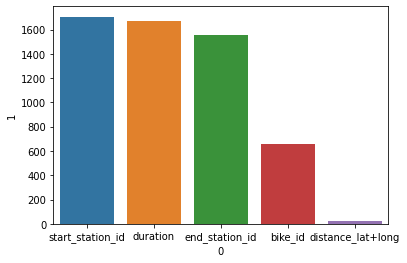

In [ ]:
### 특성 중요도
feature_imp =lgbmc.feature_importances_

sort_feature = sorted(
    list(zip(X_train.columns, feature_imp)), key=lambda x:x[1], reverse=True)[:5]

sort_feature = pd.DataFrame(sort_feature)

sns.barplot(data=sort_feature, x=sort_feature.iloc[:, 0], y=sort_feature.iloc[:, 1])

In [ ]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.0 MB/s 
     |████████████████████████████████| 133 kB 54.8 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=c04db1309c0284e3feb7ab0205a91ea0a817b150b54352121e47723f879a91f6
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [ ]:
### eli5 순열중요도

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    lgbmc, # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_test을 사용합니다.
X_test_transformed = final_model.named_steps['onehotencoder'].transform(X_test) # final_pipe 로 고치기!!
feature_names = X_test_transformed.columns.tolist() ## 표준정규화 하기 전에 ㅎㅎ column 빼야하네

X_test_transformed = final_model.named_steps['standardscaler'].transform(X_test_transformed) # final_pipe 로 고치기!!

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test);

In [ ]:

pd.Series(permuter.feature_importances_, feature_names).sort_values()

bike_id             -3.675482e-05
season_3            -2.819057e-05
end_city_2          -1.574987e-05
day_6               -1.428424e-05
day_2               -1.039288e-05
end_city_4          -9.931591e-06
move_city_2         -8.788025e-06
start_city_1        -6.801574e-06
start_city_5        -6.500818e-06
day_4               -6.359723e-06
day_3               -5.096147e-06
end_city_5          -4.113146e-06
move_city_13         0.000000e+00
move_city_15         0.000000e+00
move_city_16         0.000000e+00
move_city_17         0.000000e+00
move_city_19         0.000000e+00
move_city_12         0.000000e+00
move_city_20         0.000000e+00
move_city_21         0.000000e+00
move_city_22         0.000000e+00
move_city_18         0.000000e+00
move_city_11         0.000000e+00
move_city_14         0.000000e+00
move_city_9          0.000000e+00
move_city_8          0.000000e+00
move_city_7          0.000000e+00
move_city_5          0.000000e+00
move_city_4          0.000000e+00
move_city_3   

In [ ]:

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)


Weight,Feature
0.0631 ± 0.0004,distance_diagonal
0.0616 ± 0.0006,duration
0.0087 ± 0.0004,distance_lat+long
0.0040 ± 0.0001,is_weekend_1
0.0040 ± 0.0006,start_station_id
0.0035 ± 0.0003,end_station_id
0.0014 ± 0.0003,time_2
0.0002 ± 0.0001,season_4
0.0002 ± 0.0001,time_1
0.0001 ± 0.0001,time_3


# Extra


In [ ]:
## import OneHotEncoder

## 원핫 인코딩
encoder = OneHotEncoder(use_cat_names = True)
X_train = encoder.fit_transform(X_train) # train으로 학습 및 변형
X_test = encoder.transform(X_test) # test는 이미 학습한걸로 변형

In [ ]:
X_train.head()

,duration,start_station_id,end_station_id,bike_id,start_city,end_city,move_city,distance_diagonal,distance_lat+long,is_comeback,is_same_city,season,day,is_weekend,time
57093,5.062595,75,74,529,San Francisco,San Francisco,San Francisco_San Francisco,0.414786,0.543130,0,1,fall,Fri,weekdays,day
324569,6.814543,70,58,521,San Francisco,San Francisco,San Francisco_San Francisco,1.109170,1.177212,0,1,summer,Mon,weekdays,commute
259055,6.084499,69,57,637,San Francisco,San Francisco,San Francisco_San Francisco,0.705059,0.884438,0,1,spring,Wed,weekdays,day
105345,5.605802,77,76,411,San Francisco,San Francisco,San Francisco_San Francisco,0.418204,0.550594,0,1,winter,Wed,weekdays,day
224594,6.447306,61,65,333,San Francisco,San Francisco,San Francisco_San Francisco,0.923120,1.145849,0,1,summer,Thu,weekdays,commute


In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 넣을 때 df로 -> 시각화는 Series

scaler = StandardScaler()
scaler.fit(distance)

distance_scaled = scaler.transform(distance) 


In [ ]:
# 시계열
df.start_date, df.end_date = pd.to_datetime(df.start_date), pd.to_datetime(df.end_date)

In [ ]:
df_trip2 = df_trip[~(df_trip.start_station_id.isin(filter))]

In [ ]:
df_trip3 = df_trip[(df_trip.start_station_id.isin(filter) == False) & (df_trip.end_station_id.isin(filter) == False)]

In [ ]:
### export csv file

# X_resampled.to_csv('/content/drive/MyDrive/코드스테이츠/N2XX/section2 project/X_resampled.csv')
# y_resampled.to_csv('/content/drive/MyDrive/코드스테이츠/N2XX/section2 project/y_resampled.csv')


In [ ]:
df2 = df[df['time'].dt.minute == 0]